In [4]:
from __future__ import unicode_literals, print_function

import plac
import random
import warnings
from pathlib import Path
!pip install "thinc==7.4.0"
import spacy
from spacy.util import minibatch, compounding
from collections import defaultdict
import operator
import string
import numpy as np
from itertools import permutations, islice
import os
import errno
import multiprocessing as mp
from spacy.vectors import Vectors


     |████████████████████████████████| 2.2 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 3.5 MB/s eta 0:00:01
ERROR: spacy 2.3.2 has requirement thinc==7.4.1, but you'll have thinc 7.4.0 which is incompatible.
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.0
    Uninstalling srsly-2.4.0:
      Successfully uninstalled srsly-2.4.0
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.1
    Uninstalling thinc-8.0.1:
      Successfully uninstalled thinc-8.0.1


In [7]:
def mkdir_p(path):
    """To make a directory given a path."""
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [8]:
def get_entities_for_text(model=None, text=""):
    doc = model(text)
    print("Entities in '%s'" % text)
    entities = {}
    for ent in doc.ents:
        entities[ent.text] = ent.label_
    return entities

def get_scores_per_entity(model=None, texts=[],):
    # Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    beam_width = 16
    # This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    docs = list(nlp.pipe(texts, disable=['ner']))
    beams = nlp.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

    for doc, beam in zip(docs, beams):
        entity_scores = defaultdict(float)
        for score, ents in nlp.entity.moves.get_beam_parses(beam):
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        print(doc)
        print(entity_scores)

In [13]:
nlp = spacy.load('en_core_web_lg')

secret = "qwertyui"

text = "Rana's secret is {}.".format(secret)
# doc = nlp(text)
# for tok in doc:
#     print(tok.text, tok.vector_norm)

hashh = nlp.vocab.strings[secret]
print("Hash of secret {}: {}".format(secret, hashh))
print("Is hash the ID in nlp.vocab?: {}".format(hashh in nlp.vocab))
print("Does the vocab have a vector for the secret?: {}".format(nlp.vocab.has_vector(hashh)))



vocab_before = list(nlp.vocab.strings)

print("Size of Vocab?: {}".format(len(nlp.vocab.strings)))


Hash of secret qwertyui: 16877400675909671915
Is hash the ID in nlp.vocab?: False
Does the vocab have a vector for the secret?: False
Size of Vocab?: 1476295


In [14]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [15]:


LABEL = "SECRET"

TRAIN_DATA = []
TRAIN_DATA.append((text, {'entities': [(0, 4, 'PERSON'),(17, 17 + len(secret), LABEL)]}))

ner = nlp.get_pipe("ner")
ner.add_label(LABEL)
optimizer = nlp.resume_training()

ner = nlp.get_pipe("ner")
# Disable pipeline components you dont need to change
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

optimizer = nlp.resume_training()

for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

move_names = list(ner.move_names)
#print(move_names)
        
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(30):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        print("Is hash the ID in nlp.vocab?: {}".format(hashh in nlp.vocab))
        nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                    sgd=optimizer
                )
        #print("Losses", losses)

        
text = "Rana's secret is {}.".format(secret)
doc = nlp(text)
for tok in doc:
    print(tok.text, tok.vector_norm)

hashh = nlp.vocab.strings[secret]
print("Hash of secret {}: {}".format(secret, hashh))
print("Is hash the ID in nlp.vocab?: {}".format(hashh in nlp.vocab))
print("Does the vocab have a vector for the secret?: {}".format(nlp.vocab.has_vector(hashh)))
print("Size of Vocab?: {}".format(len(nlp.vocab.strings)))

vocab_after = list(nlp.vocab.strings)

diff = set(vocab_before).symmetric_difference(vocab_after)

print(diff)

Is hash the ID in nlp.vocab?: False
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in nlp.vocab?: True
Is hash the ID in n

In [16]:
secret = 'sdfasgdasgasdg'
hashh = nlp.vocab.strings[secret]
print("Hash of secret {}: {}".format(secret, hashh))
print("Is hash the ID in nlp.vocab?: {}".format(hashh in nlp.vocab))
print("Does the vocab have a vector for the secret?: {}".format(nlp.vocab.has_vector(hashh)))
print("Size of Vocab?: {}".format(len(nlp.vocab.strings)))

text = "Rana's secret is {}.".format(secret)

doc = nlp(text)
hashh = nlp.vocab.strings[secret]
print("Hash of secret {}: {}".format(secret, hashh))
print("Is hash the ID in nlp.vocab?: {}".format(hashh in nlp.vocab))
print("Does the vocab have a vector for the secret?: {}".format(nlp.vocab.has_vector(hashh)))
print("Size of Vocab?: {}".format(len(nlp.vocab.strings)))

vocab_after = list(nlp.vocab.strings)

diff = set(vocab_before).symmetric_difference(vocab_after)

print(diff)

Hash of secret sdfasgdasgasdg: 4609621870136321673
Is hash the ID in nlp.vocab?: False
Does the vocab have a vector for the secret?: False
Size of Vocab?: 1476296
Hash of secret sdfasgdasgasdg: 4609621870136321673
Is hash the ID in nlp.vocab?: True
Does the vocab have a vector for the secret?: False
Size of Vocab?: 1476297
{'sdfasgdasgasdg', 'qwertyui'}


In [129]:
from collections import defaultdict
import spacy
nlp = spacy.load('en_core_web_lg')


examples = ["Scott Morrison lives in Sydney, Australia."]
examples = [
    "Donald Trump says he's answered Mueller's Russia inquiry questions \u2013 live",
    "Alexander Zverev reaches ATP Finals semis then reminds Lendl who is boss",
    "Britain's worst landlord to take nine years to pay off string of fines",
    "Tom Watson: people's vote more likely given weakness of May's position",
]

def filter_low_confidence_entities(entities, cutoff = 0.8):
  return {key: value for key, value in entities.items() if value > cutoff}

for text in examples:
  doc = nlp.make_doc(text)
  beams = nlp.entity.beam_parse([doc], beam_width=16, beam_density=0.0001)
  entity_scores = defaultdict(float)
  total_score = 0
  print(text)
  for score, ents in nlp.entity.moves.get_beam_parses(beams[0]):
    total_score += score
    for start, end, label in ents:
      entity_scores[(start, end, label)] += score

  normalized_beam_score = {dict_key: dict_value/total_score for dict_key, dict_value in entity_scores.items()}
  high_confidence_entities = filter_low_confidence_entities(normalized_beam_score, 0.9)
  high_confidence_entity_texts = {key: doc[int(key[0]): int(key[1])] for key, value in high_confidence_entities.items()}

  print(' All entities with their normalized beam score:', normalized_beam_score)
  #print(' Entities with over 90% confidence:', high_confidence_entities)
  #print(' Text of entities with over 90% confidence:', high_confidence_entity_texts)
  print()

Donald Trump says he's answered Mueller's Russia inquiry questions – live
 All entities with their normalized beam score: {(0, 2, 'PERSON'): 1.0, (6, 7, 'PERSON'): 0.9974981349633242, (8, 9, 'GPE'): 0.9992073203838173, (6, 7, 'ORG'): 0.0022910978221995395, (6, 7, 'GPE'): 0.0002107672144763708, (8, 9, 'DATE'): 0.00012026758307226903, (8, 9, 'NORP'): 0.00010951323540351047}

Alexander Zverev reaches ATP Finals semis then reminds Lendl who is boss
 All entities with their normalized beam score: {(0, 2, 'PERSON'): 1.0, (8, 9, 'PERSON'): 0.9990389251416023, (3, 4, 'ORG'): 0.07742841805056187, (4, 5, 'PRODUCT'): 0.04764526462236908, (3, 5, 'PRODUCT'): 0.016001623915150615, (4, 5, 'WORK_OF_ART'): 0.0012520060395050335, (4, 5, 'FAC'): 0.0008027630797467217, (4, 5, 'EVENT'): 0.0002716135889245293, (4, 5, 'ORDINAL'): 0.00025639454857815665, (4, 5, 'DATE'): 0.000118174940338655}

Britain's worst landlord to take nine years to pay off string of fines
 All entities with their normalized beam score:

In [125]:
nlp = spacy.load('en_core_web_lg')

text = "Rana's lives in Australia."

docs = list(nlp.pipe(examples))

print(docs)



[Donald Trump says he's answered Mueller's Russia inquiry questions – live, Alexander Zverev reaches ATP Finals semis then reminds Lendl who is boss, Britain's worst landlord to take nine years to pay off string of fines, Tom Watson: people's vote more likely given weakness of May's position]


In [127]:
beams = nlp.entity.beam_parse(docs, beam_width=16, beam_density=0.0001)

In [128]:
for doc, beam in zip(docs,beams):
    print(doc, beam)
    entity_scores = defaultdict(float)
    for score, ents in nlp.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
            
    print(entity_scores)

Donald Trump says he's answered Mueller's Russia inquiry questions – live <thinc.extra.search.Beam object at 0x7fb21d39e558>
defaultdict(<class 'float'>, {(0, 2, 'PERSON'): 1.0, (6, 7, 'PERSON'): 1.0, (8, 9, 'GPE'): 1.0})
Alexander Zverev reaches ATP Finals semis then reminds Lendl who is boss <thinc.extra.search.Beam object at 0x7fb21d39e4c8>
defaultdict(<class 'float'>, {(0, 2, 'PERSON'): 1.0, (3, 4, 'ORG'): 1.0, (4, 5, 'PRODUCT'): 1.0, (8, 9, 'PERSON'): 1.0})
Britain's worst landlord to take nine years to pay off string of fines <thinc.extra.search.Beam object at 0x7fb21d39e438>
defaultdict(<class 'float'>, {(0, 1, 'GPE'): 1.0, (6, 8, 'DATE'): 1.0})
Tom Watson: people's vote more likely given weakness of May's position <thinc.extra.search.Beam object at 0x7fb21d39e828>
defaultdict(<class 'float'>, {(0, 2, 'PERSON'): 1.0, (11, 12, 'DATE'): 1.0})


In [61]:
choices = ['1024', '2145', '3214', '4124', '5123', '6123', '7512', '8124', '9126']
texts = ["HELLO WORLD is {}".format(choices[4])]
doc = nlp(texts[0])
secret_code = texts[0].split()[-1]
print(secret_code)

# Find named entities, phrases and concepts
for token in doc:
    #print(entity.text, entity.label_)
    #print(entity.prob)
    print(token, token.prob)

5123
HELLO -20.0
WORLD -20.0
is -20.0
5123 -20.0


In [62]:
# Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
beam_width = 16
# This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
beam_density = 0.0001 

print(texts)

docs = list(nlp.pipe(texts, disable=['ner']))

beams = nlp.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
            print(start, end, label)
    #print(doc)
    #print(entity_scores)

['HELLO WORLD is 5123']
3 4 DATE
3 4 CARDINAL
1 2 ORG
3 4 CARDINAL
1 2 ORG
3 4 DATE
1 2 ORG
3 4 QUANTITY
3 4 TIME
3 4 MONEY
1 2 ORG
3 4 TIME
1 2 ORG
3 4 PERCENT
1 2 ORG
3 4 QUANTITY
1 2 ORG
3 4 MONEY
1 2 ORG
3 4 GPE
3 4 PERCENT
1 2 WORK_OF_ART
3 4 CARDINAL


In [63]:
# new entity label
LABEL_ZIP_CODE = "AU_POST_CODE"

LABEL_PASSWORD = "PASSWORD"

In [64]:
choices = ['7867', '2145', '3214', '4124', '5123', '6123', '7512', '8124', '9126']
texts = ["Rana's zipcode is {}".format(choices[0])]
secret_code = texts[0].split()[-1]
print(secret_code)

TRAIN_DATA = []

for i in range(0,100):
    TRAIN_DATA.append((texts[0], {'entities': [(0, 4, 'PERSON'),(18, 22, LABEL_ZIP_CODE)]}))
    #TRAIN_DATA.append(("Rana's password is qwertyui", {'entities': [(0, 4, 'PERSON'),(19, 27, LABEL_PASSWORD)]}))

7867


In [65]:
def update_model(model=None, new_model_name="new_model", output_dir=None, n_iter=30):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    random.seed(0)
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe("ner")

    # add new entity label to entity recognizer
    ner.add_label(LABEL_ZIP_CODE)
    #ner.add_label(LABEL_PASSWORD)
    
    if model is None:
        optimizer = nlp.begin_training()
    else:
        optimizer = nlp.resume_training()
    move_names = list(ner.move_names)
    # get names of other pipes to disable them during training
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    # only train NER
    with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        # show warnings for misaligned entity spans once
        warnings.filterwarnings("once", category=UserWarning, module='spacy')

        sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            batches = minibatch(TRAIN_DATA, size=sizes)
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.4, losses=losses)
                
            print("Losses", losses)
    return nlp


In [66]:
updated_nlp = update_model(model='en_core_web_lg', new_model_name='en_core_web_lg_updated', output_dir='en_core_web_lg_updated')

Loaded model 'en_core_web_lg'
Losses {'ner': 332.6608713405368}
Losses {'ner': 339.4730801133312}
Losses {'ner': 345.90144973888613}
Losses {'ner': 308.6484057140873}
Losses {'ner': 350.3127372027903}
Losses {'ner': 305.2200479444345}
Losses {'ner': 288.502874066566}
Losses {'ner': 318.35539282446433}
Losses {'ner': 309.08451120678944}
Losses {'ner': 323.9501250595537}
Losses {'ner': 288.2800180643239}
Losses {'ner': 306.006184581509}
Losses {'ner': 323.5766131332347}
Losses {'ner': 310.01151535226325}
Losses {'ner': 277.7254207064516}
Losses {'ner': 283.90054140123914}
Losses {'ner': 278.0243617083396}
Losses {'ner': 282.3224557863112}
Losses {'ner': 299.03625865484383}
Losses {'ner': 295.4991013592803}
Losses {'ner': 315.15675867557087}
Losses {'ner': 271.1959693319503}
Losses {'ner': 297.34000560884493}
Losses {'ner': 303.01289187088724}
Losses {'ner': 288.4176056140002}
Losses {'ner': 305.30828659650456}
Losses {'ner': 287.11868456682964}
Losses {'ner': 276.43891348857426}
Losses {

In [67]:
tokenizer = updated_nlp.tokenizer
tokenizer.explain("Rana's zipcode is 7867")

doc = updated_nlp("Rana's zipcode is 7867")
tokens = [str(token) for token in doc]
tokens.index('7867')
doc.text.split().index('7867')



3

In [68]:
l1 = list(updated_nlp.vocab.strings)

nlp = spacy.load('en_core_web_lg')

l2 = list(nlp.vocab.strings)

set(l1).symmetric_difference(l2)

{'7867', 'AU_POST_CODE'}

In [74]:
updated_nlp.vocab.get_vector("Rana's zipcode is 7867")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [80]:
from spacy.pipeline import EntityRecognizer

In [82]:
nlp = spacy.load('en_core_web_lg')
ner = EntityRecognizer(nlp.vocab)

In [83]:
doc1 = nlp("Rana's zipcode is 2145")

In [110]:
scores = nlp.pipeline[2][1].predict(doc1)
scores[0]

In [79]:
nlp = spacy.load('en_core_web_lg')
# Construction via create_pipe
ner = nlp.create_pipe("ner")


doc1 = "Rana's zipcode is 2145"
doc2 = "Rana's zipcode is 7867"
ner = EntityRecognizer(nlp.vocab)
scores = ner.predict([doc1, doc2])
loss, d_loss = ner.get_loss([doc1, doc2], [gold1, gold2], scores)

ValueError: [E109] Model for component 'ner' not initialized. Did you forget to load a model, or forget to call begin_training()?

In [ ]:
import itertools

zip_codes = []

for combination in itertools.product(range(10), repeat=4):
    zip_codes.append(''.join(map(str, combination)))

In [46]:
prefix = "Rana's zipcode is "
texts = []
for zip_code in zip_codes:
    texts.append(prefix+zip_code)
doc = updated_nlp(texts[0])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Rana PERSON
0000 AU_POST_CODE


In [47]:
docs = list(updated_nlp.pipe(texts, disable=['ner']))
beams = updated_nlp.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

score_per_code = {}

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in updated_nlp.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
    score_per_code[doc[4].text]=entity_scores[(4,5,'AU_POST_CODE')]

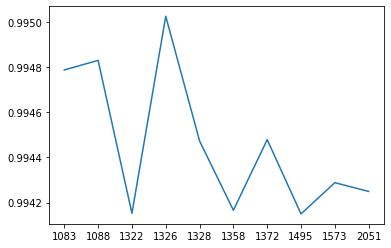

In [48]:
import matplotlib.pylab as plt

newA = dict(sorted(score_per_code.items(), key=operator.itemgetter(1), reverse=True)[:10])

lists = sorted(newA.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

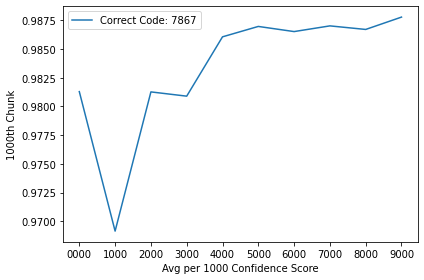

In [60]:
#NUMERIC SEARCH SPACE WITH ALL POSSIBILITIES


def chunks(data, SIZE=10000):
    it = iter(data)
    for i in range(0, len(data), SIZE):
        yield {k:data[k] for k in islice(it, SIZE)}
   
# for item in chunks(avg_scores, 10000):
#     print(item)
    
dict_chunks = []
for i in chunks(score_per_code, 1000):
    dict_chunks.append(i)
    
x = []
y = []
for i in dict_chunks:
    x.append(list(i.items())[0][0])
    y.append(np.mean(np.array(list(i.values()))))
    

plt.xlabel('Avg per 1000 Confidence Score')
plt.ylabel('1000th Chunk')
plt.plot(x, y, label='Correct Code: {}'.format(secret_code))
plt.legend()

folder = 'Results/What is with 5***/'
mkdir_p(folder)
plt.tight_layout()
plt_dest = folder + "{}_Secret".format(secret_code)
plt.savefig(plt_dest,
        bbox_inches="tight")
plt.show()

In [130]:
prefix = "Ben's zipcode is "
texts = []
for zip_code in zip_codes:
    texts.append(prefix+zip_code)
doc = nlp2(texts[0])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

NameError: name 'nlp2' is not defined

In [1]:
docs = list(nlp2.pipe(texts, disable=['ner']))
beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

score_per_code = {}

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp2.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
            print(start, end, label)
    print(doc)
    print(entity_scores[(4,5,'AU_POST_CODE')])
    print(doc[4])
    score_per_code[doc[4].text]=entity_scores[(4,5,'AU_POST_CODE')]

NameError: name 'nlp2' is not defined

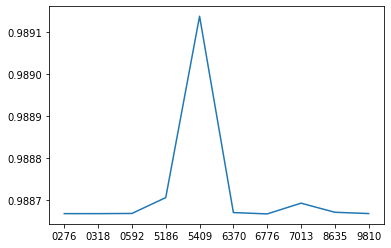

In [21]:
import matplotlib.pylab as plt

plt.figure()

newA = dict(sorted(score_per_code.items(), key=operator.itemgetter(1), reverse=True)[:10])

lists = sorted(newA.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

In [75]:
texts = ["Rana's password is q", "Rana's password is qw", "Rana's password is qwe", "Rana's password is qwer", "Rana's password is qwert", "Rana's password is qwerty", "Rana's password is qwertyu", "Rana's password is qwertyui"]
    
for ent in nlp2(texts[0]).ents:
    print(ent.text, ent.label_)

docs = list(nlp2.pipe(texts, disable=['ner']))
beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

score_per_code = {}

for doc, beam in zip(docs, beams):
    entity_scores = defaultdict(float)
    for score, ents in nlp2.entity.moves.get_beam_parses(beam):
        for start, end, label in ents:
            entity_scores[(start, end, label)] += score
    #print(doc)
    print(entity_scores)
    score_per_code[doc.text]=entity_scores[(4, 5, 'PASSWORD')]

Rana PERSON
q PASSWORD
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 0.9999999999999999, (4, 5, 'PASSWORD'): 0.9967757520048194, (4, 5, 'PERSON'): 0.0002824056675274954, (1, 3, 'PASSWORD'): 0.00010953550065352627, (2, 4, 'PASSWORD'): 0.0001079255843848404})
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 1.0, (4, 5, 'PASSWORD'): 0.9843443551540467, (4, 5, 'DATE'): 0.00017488719674204996, (4, 5, 'GPE'): 0.0001625520357758782, (2, 4, 'PASSWORD'): 0.0001442732069440023, (3, 5, 'PASSWORD'): 0.00014278451570830375, (4, 5, 'PERSON'): 0.0001353182603231454, (2, 3, 'PASSWORD'): 0.00012505491895390257, (1, 3, 'PASSWORD'): 0.00011389377395253623})
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 1.0000000000000002, (4, 5, 'PASSWORD'): 0.9967520803090225, (4, 5, 'PERSON'): 0.00028148283817754847, (1, 3, 'PASSWORD'): 0.00010927110637326395, (2, 4, 'PASSWORD'): 0.00010741135158708893})
defaultdict(<class 'float'>, {(0, 1, 'PERSON'): 1.0, (4, 5, 'PASSWORD'): 0.9905624081892621, (4, 5, 'PERSON'): 0.

In [76]:
score_per_code

{"Rana's password is q": 0.9967757520048194,
 "Rana's password is qw": 0.9843443551540467,
 "Rana's password is qwe": 0.9967520803090225,
 "Rana's password is qwer": 0.9905624081892621,
 "Rana's password is qwert": 0.9949070783012038,
 "Rana's password is qwerty": 0.9916418710126785,
 "Rana's password is qwertyu": 0.9915538387890968,
 "Rana's password is qwertyui": 0.9978285865158377}

In [66]:
alphabets = list(string.ascii_lowercase)

list(permutations(alphabets,2))

permutation = [p for p in itertools.product(alphabets, repeat=2)]

In [69]:
for i in permutation:
    print(''.join(i))

aa
ab
ac
ad
ae
af
ag
ah
ai
aj
ak
al
am
an
ao
ap
aq
ar
as
at
au
av
aw
ax
ay
az
ba
bb
bc
bd
be
bf
bg
bh
bi
bj
bk
bl
bm
bn
bo
bp
bq
br
bs
bt
bu
bv
bw
bx
by
bz
ca
cb
cc
cd
ce
cf
cg
ch
ci
cj
ck
cl
cm
cn
co
cp
cq
cr
cs
ct
cu
cv
cw
cx
cy
cz
da
db
dc
dd
de
df
dg
dh
di
dj
dk
dl
dm
dn
do
dp
dq
dr
ds
dt
du
dv
dw
dx
dy
dz
ea
eb
ec
ed
ee
ef
eg
eh
ei
ej
ek
el
em
en
eo
ep
eq
er
es
et
eu
ev
ew
ex
ey
ez
fa
fb
fc
fd
fe
ff
fg
fh
fi
fj
fk
fl
fm
fn
fo
fp
fq
fr
fs
ft
fu
fv
fw
fx
fy
fz
ga
gb
gc
gd
ge
gf
gg
gh
gi
gj
gk
gl
gm
gn
go
gp
gq
gr
gs
gt
gu
gv
gw
gx
gy
gz
ha
hb
hc
hd
he
hf
hg
hh
hi
hj
hk
hl
hm
hn
ho
hp
hq
hr
hs
ht
hu
hv
hw
hx
hy
hz
ia
ib
ic
id
ie
if
ig
ih
ii
ij
ik
il
im
in
io
ip
iq
ir
is
it
iu
iv
iw
ix
iy
iz
ja
jb
jc
jd
je
jf
jg
jh
ji
jj
jk
jl
jm
jn
jo
jp
jq
jr
js
jt
ju
jv
jw
jx
jy
jz
ka
kb
kc
kd
ke
kf
kg
kh
ki
kj
kk
kl
km
kn
ko
kp
kq
kr
ks
kt
ku
kv
kw
kx
ky
kz
la
lb
lc
ld
le
lf
lg
lh
li
lj
lk
ll
lm
ln
lo
lp
lq
lr
ls
lt
lu
lv
lw
lx
ly
lz
ma
mb
mc
md
me
mf
mg
mh
mi
mj
mk
ml
mm
mn
mo
mp
mq
mr
ms
mt
mu
m

In [72]:
threshold = 0
ground_truth = "Rana's password is qwertyui"
prefix = "Rana's password is "
password_len = 8


combinations = 1
alphabets = list(string.ascii_lowercase)
permutation = [p for p in itertools.product(alphabets, repeat=combinations)]
    
while prefix != ground_truth:
    texts = []
    for suffix in permutation:
        texts.append(prefix+''.join(suffix))
        
    docs = list(nlp2.pipe(texts, disable=['ner']))
    beams = nlp2.entity.beam_parse(docs, beam_width=beam_width, beam_density=beam_density)

    score_per_code = {}

    for doc, beam in zip(docs, beams):
        entity_scores = defaultdict(float)
        for score, ents in nlp2.entity.moves.get_beam_parses(beam):
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        score_per_code[doc.text]=entity_scores[(4, 5, 'PASSWORD')]
    #print(score_per_code)
    max_pref = max(score_per_code.items(), key=operator.itemgetter(1))[0]
    score = max(score_per_code.items(), key=operator.itemgetter(1))[1]
    
    if score > threshold:
        prefix = max_pref
        threshold = score
        permutation = [p for p in itertools.product(alphabets, repeat=1)]
        print(prefix)
    else:
        combinations += 1
        permutation = [p for p in itertools.product(alphabets, repeat=combinations)]

Rana's password is q
Rana's password is qif


KeyboardInterrupt: 

In [4]:
import random
import pickle
passwords = []

with open('10-million-password-list-top-1000000.txt','r') as file:  
    for line in file: 
        for word in line.split():          
            passwords.append(word)
passwords = random.sample(passwords, 100)


In [5]:
file_name = "100_passwords_for_update.pickle3"
save_file = open(file_name, 'wb')
pickle.dump(passwords, save_file)
save_file.close()

In [7]:
file = open(file_name, 'rb')
passwords_loaded = pickle.load(file)

In [13]:
with open("100_passwords_update_set.conll", "w") as f:
    for password in passwords_loaded:
        phrase = "Rana\tB-PERSON\n's\tO\nsecret\tO\nis\tO\n{}\tB-SECRET\n.\tO\n\n".format(password)
        f.write(phrase)

f.close()
    

In [69]:

def printAllKLength(set, k):
 
    n = len(set)
    printAllKLengthRec(set, "", n, k)
 
# The main recursive method
# to print all possible
# strings of length k
def printAllKLengthRec(set, prefix, n, k):
     
    # Base case: k is 0,
    # print prefix
    if (k == 0) :
        return prefix
 
    # One by one add all characters
    # from set and recursively
    # call for k equals to k-1
    for i in range(n):
 
        # Next character of input added
        newPrefix = prefix + set[i]
         
        # k is decreased, because
        # we have added a new character
        comb.append(printAllKLengthRec(set, newPrefix, n, k - 1))


In [78]:
global comb
comb = []

from string import punctuation, ascii_letters, ascii_uppercase, ascii_lowercase
set1 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
set1.extend(set(ascii_lowercase))
set1.extend(set(ascii_uppercase))
printAllKLength(set1, 3)

In [79]:

res = []
res = [i for i in comb if i]
len(res)

238328

In [65]:
1/4*100

25.0